In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.utils import resample

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix

%matplotlib inline

In [2]:
df = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [3]:
# See if there are any NaNs
df.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [4]:
# Look for imbalance in the training data
df['Response'].value_counts(normalize=True)

0    0.877437
1    0.122563
Name: Response, dtype: float64

#### We see that 88% of the class is Response=0, while only 12% is Response=1. To deal with this:
1. I first test a LogisticRegression model with the imbalanced data.
2. I test a RandomForestClassifier model with the imbalanced data.
3. I resample the imbalanced variable (Response=1) and test a RandomForestClassifier model

# Data preprocessing

In [5]:
# 1. Remove rows with NaNs in the Response column (here there aren't any NaNs)
df = df.dropna(subset=['Response'], axis=0)

In [6]:
# 2.  

# Create X with only feature columns
X = df.drop(['Response','id'], axis=1)
# Create y with Response column
y = df['Response'] 
# Drop 'id' column also from df_test
df_test = df_test.drop(['id'], axis=1)

In [7]:
def create_dummy(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables to dummy
    cat_cols - list of strings associated with the names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. dummy columns for each of the categorical columns in cat_cols
            3. if dummy_na is True - it also contains dummy columns for the NaN values
            4. Use a prefix of the column name with an underscore (_) for separating 
    '''
    
    df = pd.concat([df.select_dtypes(exclude='object'), pd.get_dummies(df[cat_cols], prefix_sep='_', drop_first=False, dummy_na=dummy_na)], axis=1)
    return df

### Categorical values - method 1:
#### (This is not the chosen preprocessing method in the analysis)

One way of dealing with categorical values would be to create dummy columns only for the variables with initial dtype=object (here 'Gender', 'Vehicle_Age', 'Vehicle_Damage'). Then we can fill any NaNs in the remaining numerical and categorical variables using mode() (the mean wouldn't make sense in the case of the categorical variables).

In [8]:
# 3-1. Select categorical variables 

#cat_vars1 = X.select_dtypes(include=['object']).columns

In [9]:
# 4-1. Create dummy columns

#X = create_dummy(X, cat_vars1, dummy_na=True)
#df_test = create_dummy(df_test, cat_vars1, dummy_na=True) 

In [10]:
# 5-1. Fill any numerical/categorical NaNs with mode()

#fill_mean = lambda col: col.fillna(col.mode())
#X = X.apply(fill_mean, axis=0)
#df_test = df_test.apply(fill_mean, axis=0)

### Categorical values - method 2:
#### (This is the chosen preprocessing method in the analysis)

Another way of dealing with all categorical values would be to convert all of them to dtype=object and create dummy columns for all categorical variables. Then we can fill any NaNs in the remaining numerical variables using mean().



In [11]:
# 3-2. Convert all categorical variables to dtype=object 

X = X.astype({'Driving_License': object, 'Region_Code': object, 'Previously_Insured': object, 'Policy_Sales_Channel': object})
df_test = df_test.astype({'Driving_License': object, 'Region_Code': object, 'Previously_Insured': object, 'Policy_Sales_Channel': object})

cat_vars2 = X.select_dtypes(include=['object']).columns

In [12]:
# 4-2. Create dummy columns

X = create_dummy(X, cat_vars2, dummy_na=True)
df_test = create_dummy(df_test, cat_vars2, dummy_na=True) 

# Check if there are differences in the dummy column names of the two dataframes.
# If a dataframe misses a dummy column, then add it and fill it with zeros.
for col in set(X.columns).symmetric_difference(set(df_test.columns)): 
    if col in X.columns:
        df_test[col]=0
    else:
        X[col]=0

In [13]:
# 5-2. Fill any numerical NaNs with mean()

fill_mean = lambda col: col.fillna(col.mean())
X = X.apply(fill_mean, axis=0)
df_test = df_test.apply(fill_mean, axis=0)

In [14]:
# 6. Split into train/validation/test
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.20, random_state=42)
X_test = df_test.copy()

# Modeling

### 1. Testing a LogisticRegression model (with imbalanced data)

In [15]:
# Scaling data for LogisticRegression

#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_val = scaler.transform(X_val)
#X_test = scaler.transform(X_test)

In [16]:
# 7. Instantiate model
model1 = LogisticRegression(solver='liblinear',random_state=42) # For binary classification

In [17]:
# 8. Fit to model
model1.fit(X_train, y_train)

LogisticRegression(random_state=42, solver='liblinear')

In [18]:
# 9. Predict using validation set
preds1 = model1.predict(X_val)
probs1 = model1.predict_proba(X_val)[:,1]

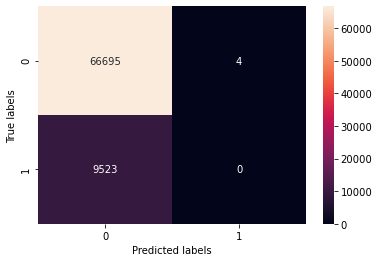

In [19]:
# 10. Confusion matrix
matrix1 = confusion_matrix(y_val, preds1)
ax = plt.subplot();
sns.heatmap(matrix1, annot=True, ax = ax, fmt='g');
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');

In [20]:
# 11. Score model predictions
score_acc1 = accuracy_score(y_val, preds1)
score_roc1 = roc_auc_score(y_val, preds1) # Suggested Kaggle metric
score_acc1, score_roc1

(0.8750098396788328, 0.49997001454294665)

#### Due to the imbalance for Response=1, the model cannot predict positive responses.

### 2. Testing a RandomForestClassifier model (with imbalanced data)

In [21]:
# 7. Instantiate model
model2 = RandomForestClassifier()

In [22]:
# 8. Fit to model
model2.fit(X_train, y_train)

RandomForestClassifier()

In [23]:
# 9. Predict using validation set
preds2 = model2.predict(X_val)
probs2 = model2.predict_proba(X_val)[:,1]

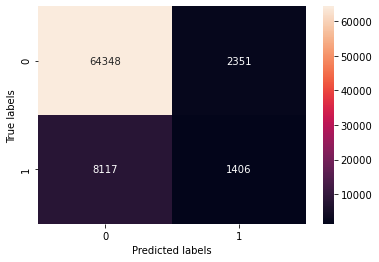

In [24]:
# 10. Confusion matrix
matrix2 = confusion_matrix(y_val, preds2)
ax = plt.subplot();
sns.heatmap(matrix2, annot=True, ax = ax, fmt='g');
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');

In [25]:
# 11. Score model predictions
score_acc2 = accuracy_score(y_val, preds2)
score_roc2 = roc_auc_score(y_val, preds2) 
score_acc2, score_roc2

(0.8626643226365092, 0.5561973224252644)

#### The RandomForestClassifier is better on dealing with imbalanced data.

### 3. Resample imbalanced class with bootstrapping and use a RandomForestClassifier model 

In [26]:
df0 = df[df['Response']==0]
df1 = df[df['Response']==1]
 
# Resample (replace=True:sample with replacement, n_samples:same as balanced class)
df1_boot = resample(df1, replace=True, n_samples=len(df0), random_state=42)
 
# Merge
df_res = pd.concat([df0, df1_boot])
df_res['Response'].value_counts(normalize=True)

1    0.5
0    0.5
Name: Response, dtype: float64

In [27]:
# Repeat preprocessing

X_res = df_res.drop(['Response','id'], axis=1)
y_res = df_res['Response'] 

X_res = X_res.astype({'Driving_License': object, 'Region_Code': object, 'Previously_Insured': object, 'Policy_Sales_Channel': object})
X_res = create_dummy(X_res, cat_vars2, dummy_na=True)

for col in set(X_res.columns).symmetric_difference(set(df_test.columns)): 
    if col in X_res.columns:
        df_test[col]=0
    else:
        X_res[col]=0

        
X_res = X_res.apply(fill_mean, axis=0)
X_res_train, X_res_val, y_res_train, y_res_val = train_test_split(X_res, y_res, test_size=.20, random_state=42)


In [28]:
# 7. Instantiate model
model3 = RandomForestClassifier()

In [29]:
# 8. Fit to model
model3.fit(X_res_train, y_res_train)

RandomForestClassifier()

In [30]:
# 9. Predict using validation set
preds3 = model3.predict(X_res_val)
probs3 = model3.predict_proba(X_res_val)[:,1]

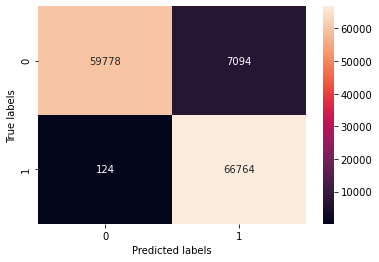

In [31]:
# 10. Confusion matrix
matrix3 = confusion_matrix(y_res_val, preds3)
ax = plt.subplot();
sns.heatmap(matrix3, annot=True, ax = ax, fmt='g');
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');

In [32]:
# 11. Score model predictions
score_acc3 = accuracy_score(y_res_val, preds3)
score_roc3 = roc_auc_score(y_res_val, preds3) 
score_acc3, score_roc3

(0.9460376794258373, 0.9460314456089524)

#### This model is better to use for predicting unknown data.

### Predict on unknown test data

In [36]:
y_test_preds = model3.predict(X_test)
y_test_preds

array([0, 1, 0, ..., 0, 0, 0])

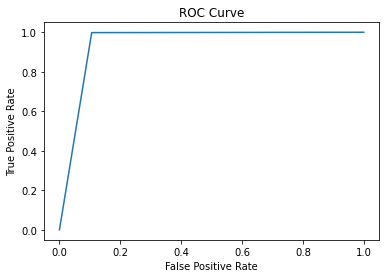

In [35]:
# ROC curve

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_res_val, preds3)
plt.plot(false_positive_rate, true_positive_rate)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()